In [63]:
# -*- coding: utf-8 -*-
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or
# implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from sklearn.feature_selection import mutual_info_regression

# Fáza 3 - Strojové učenie

In [181]:
# Load "Preprocessing Data"
df = pd.read_csv("test_data.csv", sep=',')

df_processes = pd.read_csv("processes.csv", sep='\t')
df_connections = pd.read_csv("connections.csv", sep='\t')

df_processes = df_processes[
    ["imei", "ts", "mwra", "p.android.gm", "p.android.documentsui", "p.system", "p.android.externalstorage",
     "p.android.settings", "p.android.chrome"]]
df_connections = df_connections[["imei", "ts", "mwra", "c.katana", "c.dogalize", "c.android.chrome", "c.android.gm"]]

df = df_connections.merge(df_processes, on=['imei', 'ts'], how='outer')

TRAIN = 0.8

df.head()

df = df.drop(columns=['ts'])

X = df.drop(columns=['mwra_x', 'mwra_y'])  # Odstránime stĺpce mwra_x a mwra_y
y = df['mwra_y']  # Cieľová premenná je 'mwra_y'

# Rozdelenie na tréningovú a testovaciu množinu
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN, random_state=42)

In [74]:
def round_mwra(df, column_name):
    # Define
    conditions = [
        (df[column_name] >= -2) & (df[column_name] <= 0.49),
        (df[column_name] >= 0.5) & (df[column_name] <= 2)
    ]
    # values 0 & 1
    values = [0, 1]
    
    df[column_name] = pd.cut(
        df[column_name], bins=[-float('inf'), 0.49, float('inf')],
        labels=[0, 1]
    ).astype(int)
    return df

round_mwra(df, 'mwra_x')
round_mwra(df, 'mwra_y')

,Unnamed: 0,imei,mwra_x,c.katana,c.dogalize,c.android.chrome,c.android.gm,mwra_y,p.android.gm,p.android.documentsui,p.system,p.android.externalstorage,p.android.settings,p.android.chrome
0,4962,-0.885659,0,0.384953,1.024166,-2.005651,0.048865,0,1.581772,2.336805,0.831462,1.445738,-0.863830,0.228189
1,10811,-0.059919,1,-0.322187,-0.357271,0.255273,-0.267167,1,-0.495403,1.171597,-1.006791,-0.142534,0.977446,-0.797237
2,12528,1.465946,1,-1.132058,-1.798600,1.195226,-1.685932,1,-0.004034,-0.435520,-1.155371,-0.246857,0.739112,-0.619998
3,8359,-0.059919,0,1.837001,-0.374846,-1.044862,-1.634371,0,1.318174,0.396704,-0.174300,-0.070513,-0.557212,-1.095027
4,1022,-1.038245,0,2.259301,0.830553,-2.157431,0.490569,0,0.059284,-0.055558,-0.517833,-0.053458,-0.527872,-0.465043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029,15043,1.465946,1,-0.535566,0.904431,0.231311,1.059819,1,-0.145564,0.032537,0.913974,1.433948,-0.498085,0.895839
3030,5436,-0.885659,1,-0.357472,-0.213311,0.148853,0.032231,1,-0.758423,0.134833,-1.158237,0.606700,0.994598,-0.163812
3031,3120,-0.885659,0,1.854427,0.483189,-1.029730,0.602080,0,-0.945276,-1.419170,-0.401219,-1.446484,0.405081,-1.840993
3032,1943,-1.038245,0,0.082413,-0.302745,-1.706615,0.381628,0,1.371405,0.246977,0.041752,-1.277159,0.108187,-1.771428


Keďže sme spravili v minulej fázy chybu, bohužial budeme musieť s ňou pracovať, ale keďže treba dáta v určitom formáte pre strom, tak som si dovoli mwra_x a mwra_y takto upraviť.

## 3.1 Jednoduchý klasifikátor na základe závislosti v dátach

### 3.1.A

In [202]:
def calculate_entropy(data, target_column): 
    total_rows = len(data)
    target_values = data[target_column].unique()

    entropy = 0
    for value in target_values:
        # Calculate the proportion of instances with the current value
        value_count = len(data[data[target_column] == value])
        proportion = value_count / total_rows
        entropy -= proportion * math.log2(proportion) if proportion != 0 else 0

    return entropy

In [203]:
def calculate_information_gain(data, feature, target_column):
    # Calculate weighted average entropy for the feature
    unique_values = data[feature].unique()
    weighted_entropy = 0

    for value in unique_values:
        subset = data[data[feature] == value]
        proportion = len(subset) / len(data)
        weighted_entropy += proportion * calculate_entropy(subset, target_column)

    # Calculate information gain
    information_gain = entropy_outcome - weighted_entropy

    return information_gain


In [206]:
# Assuming 'df' is the DataFrame and 'mwra_x' is the target column
entropy_outcome = calculate_entropy(df, 'mwra_x')  # Calculate entropy for the target column

# Now let's calculate entropy and information gain for each feature (except target column)
for column in df.columns:
    if "Unnamed" not in column:  # Skip columns with 'Unnamed' in their name
        if column != 'mwra_x':  # Skip the target column 'mwra_x'
            # Calculate entropy for the feature column
            feature_entropy = calculate_entropy(df, column)
            information_gain = calculate_information_gain(df, column, 'mwra_x')
            print(f"{column} - Entropy: {feature_entropy:.3f}, Information Gain: {information_gain:.3f}")


imei - Entropy: 8.938, Information Gain: 0.030
c.katana - Entropy: 13.803, Information Gain: 0.948
c.dogalize - Entropy: 13.803, Information Gain: 0.946
c.android.chrome - Entropy: 13.806, Information Gain: 0.948
c.android.gm - Entropy: 13.808, Information Gain: 0.947
mwra_y - Entropy: 0.953, Information Gain: 0.953
p.android.gm - Entropy: 13.804, Information Gain: 0.948
p.android.documentsui - Entropy: 13.798, Information Gain: 0.945
p.system - Entropy: 13.801, Information Gain: 0.944
p.android.externalstorage - Entropy: 13.804, Information Gain: 0.947
p.android.settings - Entropy: 13.802, Information Gain: 0.944
p.android.chrome - Entropy: 13.805, Information Gain: 0.946


Decision Trees for Group 1:


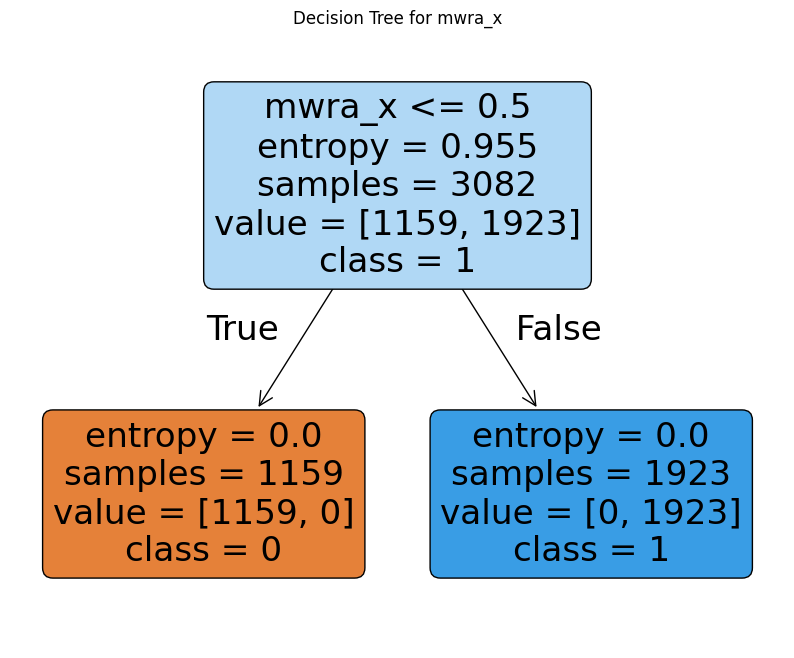

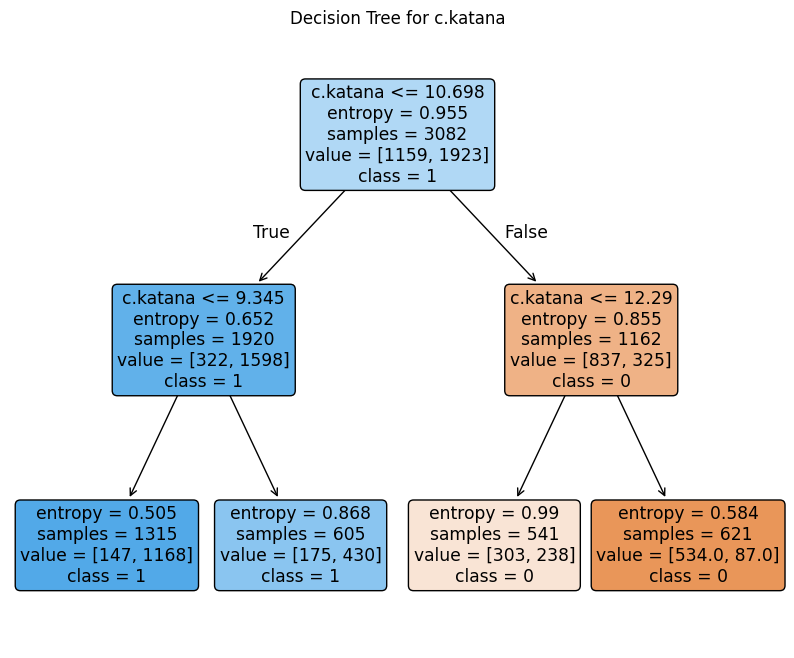

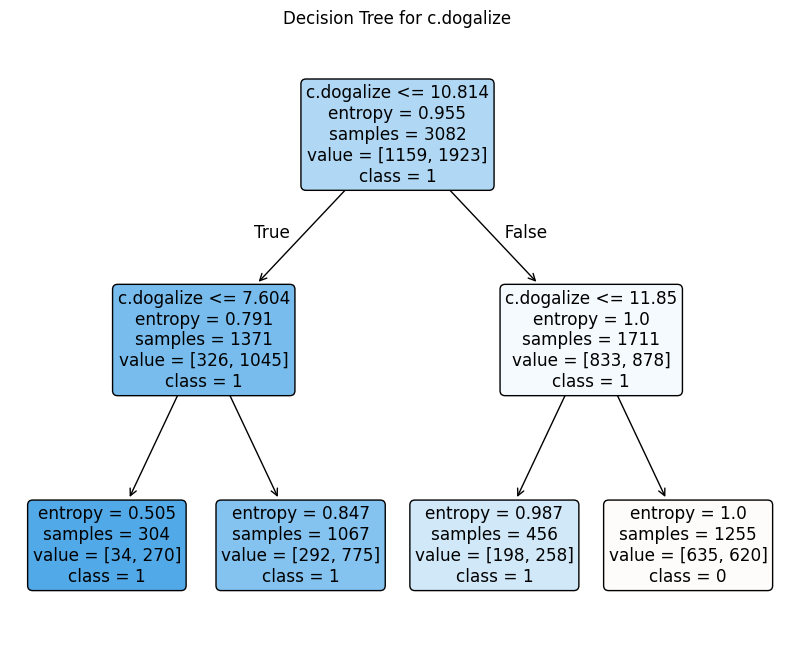

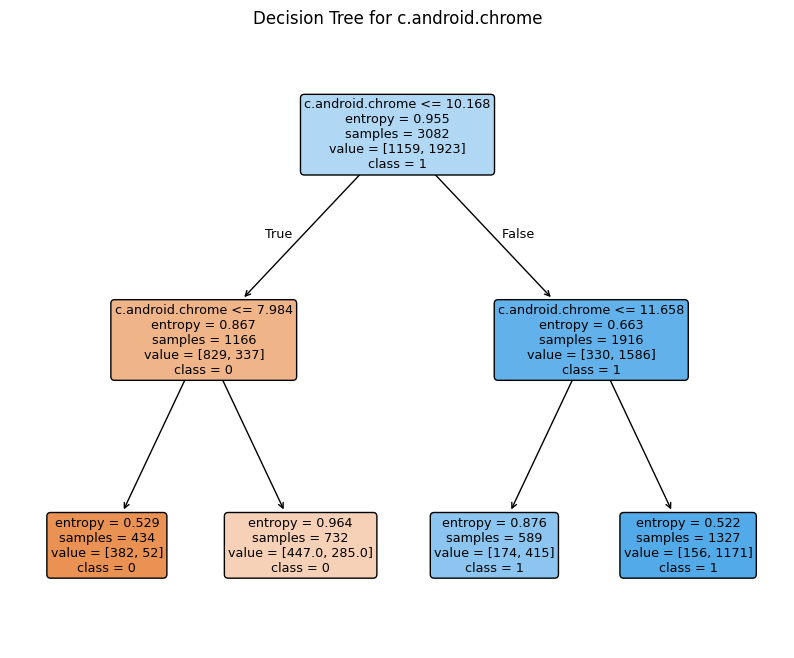

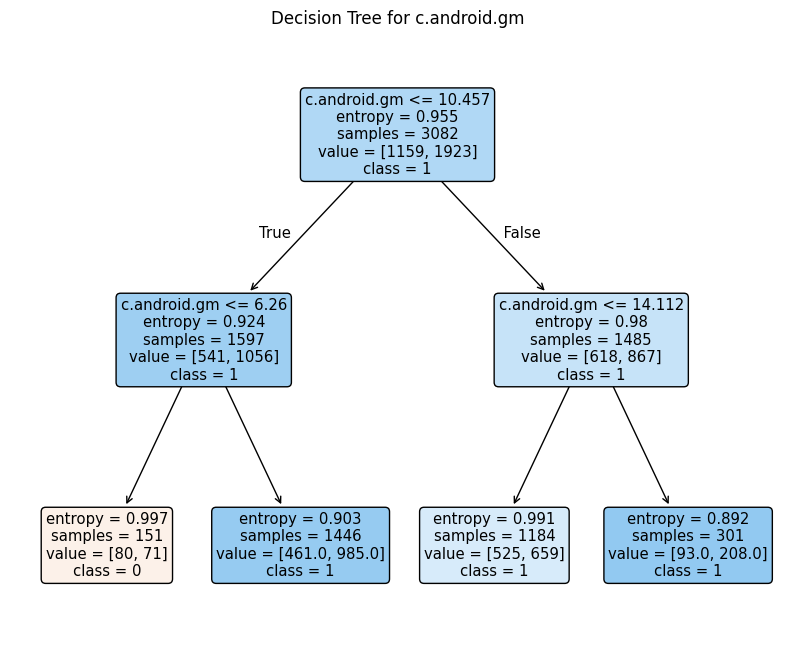

Decision Trees for Group 2:


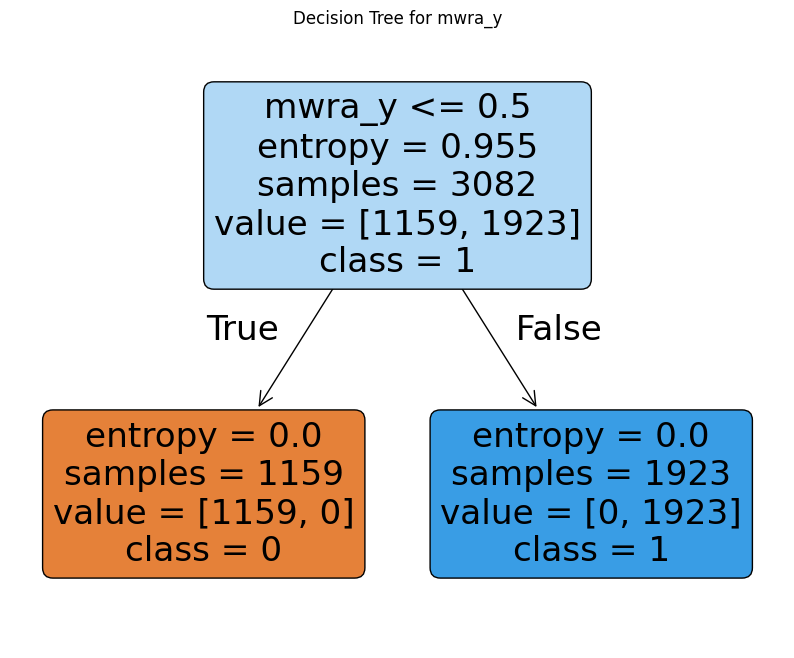

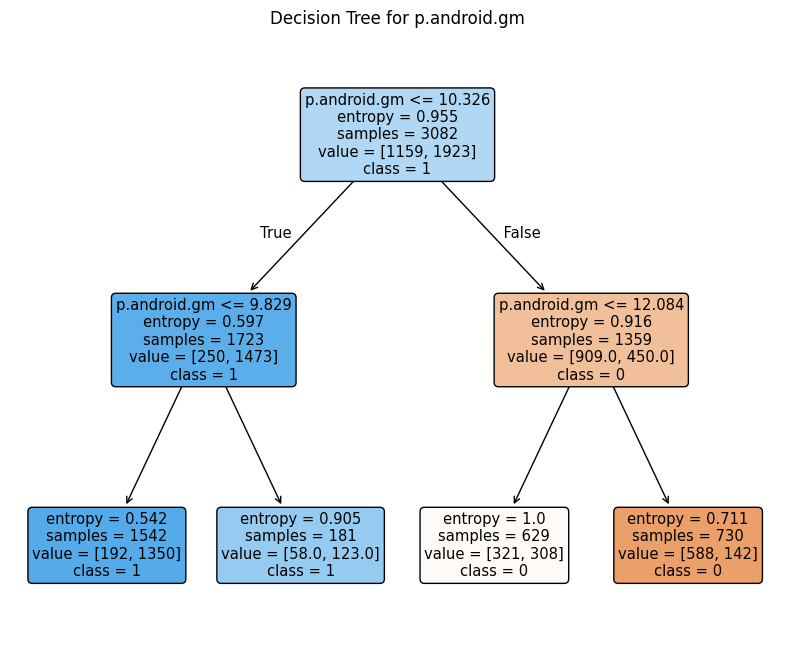

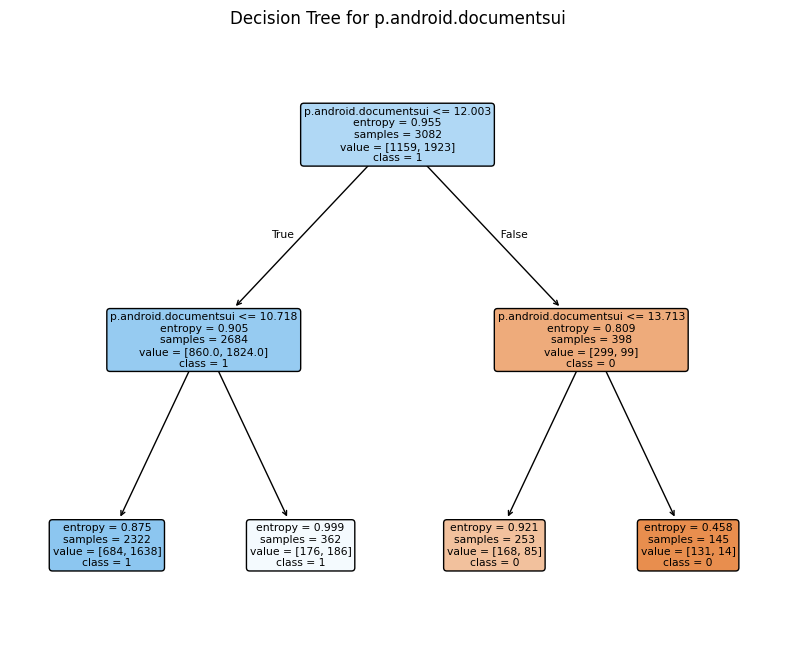

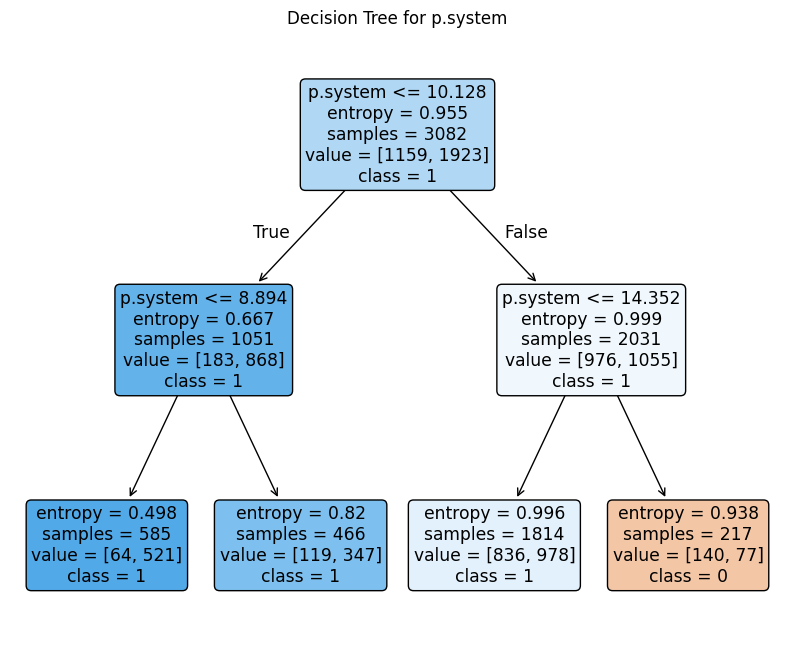

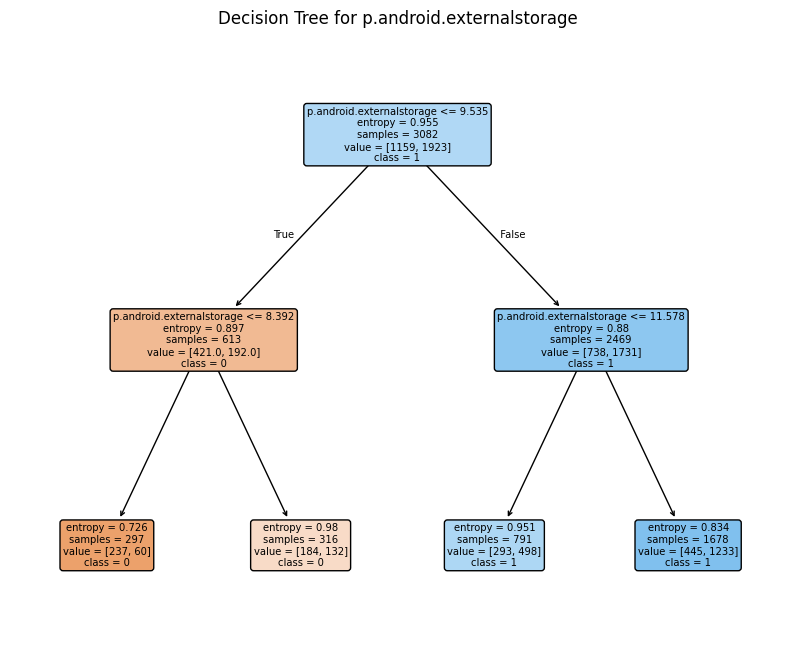

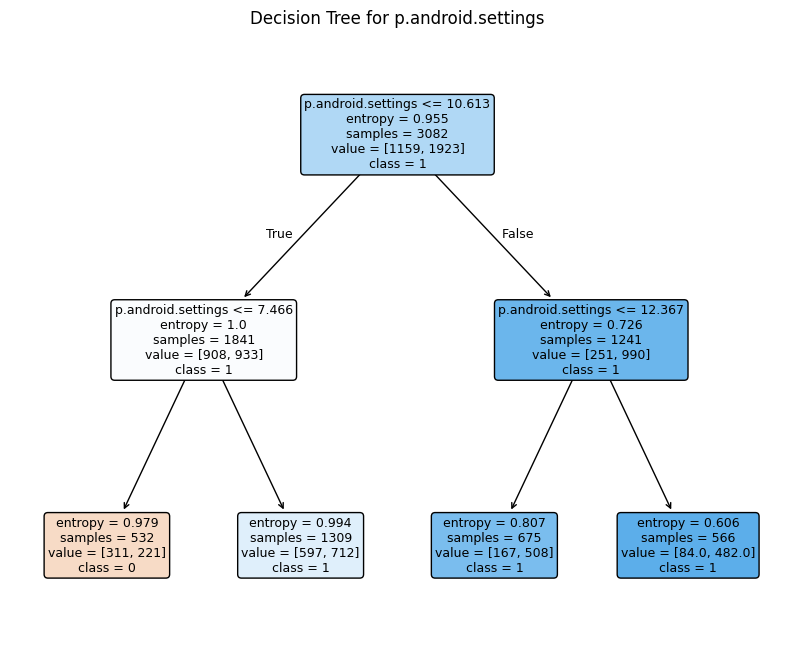

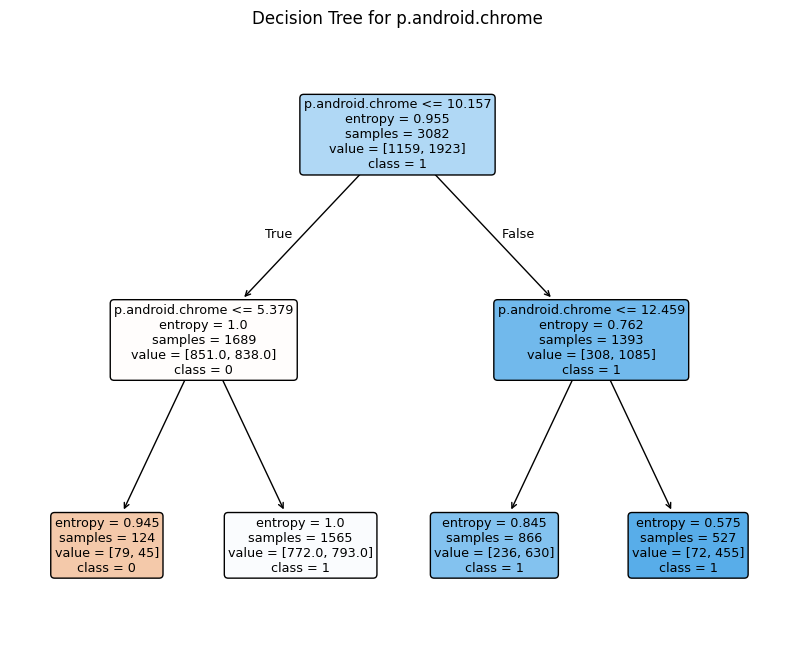

In [209]:
# Feature groups
group_1 = ["mwra_x", "c.katana", "c.dogalize", "c.android.chrome", "c.android.gm"]
group_2 = ["mwra_y", "p.android.gm", "p.android.documentsui", "p.system", "p.android.externalstorage", "p.android.settings", "p.android.chrome"]

# Function to create, plot, and evaluate decision trees for a feature group
def create_plot_and_evaluate_trees(df, feature_group, target_column, max_depth=5):
    results = []
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(df[feature_group], df[target_column], test_size=0.8, random_state=42)
    
    for feature in feature_group:
        # Create and train a decision tree for the current feature
        clf = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
        X = df[[feature]]  # Use the current feature as input
        y = df[target_column]  # Use the target column
        clf.fit(X_train[[feature]], y_train)
        
        # Predict on the training set
        y_train_pred = clf.predict(X_train[[feature]])
        # Predict on the test set
        y_test_pred = clf.predict(X_test[[feature]])
        
        # Evaluate training accuracy and classification report
        train_accuracy = accuracy_score(y_train, y_train_pred)
        train_report = classification_report(y_train, y_train_pred, target_names=['0', '1'])
        
        # Evaluate test accuracy and classification report
        test_accuracy = accuracy_score(y_test, y_test_pred)
        test_report = classification_report(y_test, y_test_pred, target_names=['0', '1'])
        
        results.append({
            "feature": feature, 
            "train_accuracy": train_accuracy, 
            "train_report": train_report,
            "test_accuracy": test_accuracy, 
            "test_report": test_report
        })
        
        # Plot the decision tree
        plt.figure(figsize=(10, 8))
        plot_tree(
            clf,
            feature_names=[feature],
            class_names=['0', '1'],
            filled=True,
            rounded=True
        )
        plt.title(f"Decision Tree for {feature}")
        plt.show()
        
    return results

# Generate and evaluate trees for the first group
print("Decision Trees for Group 1:")
results_group_1 = create_plot_and_evaluate_trees(df, group_1, target_column="mwra_x", max_depth=2)

# Generate and evaluate trees for the second group
print("Decision Trees for Group 2:")
results_group_2 = create_plot_and_evaluate_trees(df, group_2, target_column="mwra_y", max_depth=2)



### 3.1.B

In [211]:
from sklearn.metrics import classification_report

# Function to print classification reports for both training and test sets
def print_classification_reports(results):
    for result in results:
        print(f"Feature: {result['feature']}")
        # Print Training Accuracy and Classification Report
        print(f"Training Accuracy: {result['train_accuracy']:.3f}")
        print(f"Training Classification Report:\n{result['train_report']}")
        
        # Print Test Accuracy and Classification Report
        print(f"Test Accuracy: {result['test_accuracy']:.3f}")
        print(f"Test Classification Report:\n{result['test_report']}")
        print("-" * 60)

# Assuming results_group_1 and results_group_2 are defined from the previous function
print("Classification Reports for Group 1:")
print_classification_reports(results_group_1)

print("\nClassification Reports for Group 2:")
print_classification_reports(results_group_2)

Classification Reports for Group 1:
Feature: mwra_x
Training Accuracy: 1.000
Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1159
           1       1.00      1.00      1.00      1923

    accuracy                           1.00      3082
   macro avg       1.00      1.00      1.00      3082
weighted avg       1.00      1.00      1.00      3082

Test Accuracy: 1.000
Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4582
           1       1.00      1.00      1.00      7750

    accuracy                           1.00     12332
   macro avg       1.00      1.00      1.00     12332
weighted avg       1.00      1.00      1.00     12332

------------------------------------------------------------
Feature: c.katana
Training Accuracy: 0.790
Training Classification Report:
              precision    recall  f1-score   suppor

### 3.1.C   
Model je *overfit*, ... potom dokončím : >